In [1]:
import numpy as np
import pandas as pd
import keras as K
import matplotlib.pyplot as plt
import multiprocessing
import time
import collections
import sys
import signal

%matplotlib inline

Using TensorFlow backend.


In [0]:
# The original class can be imported like this:
from keras.preprocessing.image import ImageDataGenerator



In [0]:
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    img -= 0.5
    return img * 2

In [0]:
def plot_images(img_gen, title):
    fig, ax = plt.subplots(6, 6, figsize=(10, 10))
    plt.suptitle(title, size=32)
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for (imgs, labels) in img_gen:
        for i in range(6):
            for j in range(6):
                if i*6 + j < 32:
                    ax[i][j].imshow(imgs[i*6 + j])
        break    

In [5]:
from keras.datasets.cifar10 import load_data
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = load_data()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

170500096/170498071 [==============================] - 6s 0us/step


4 process, duration: 0.8895909786224365


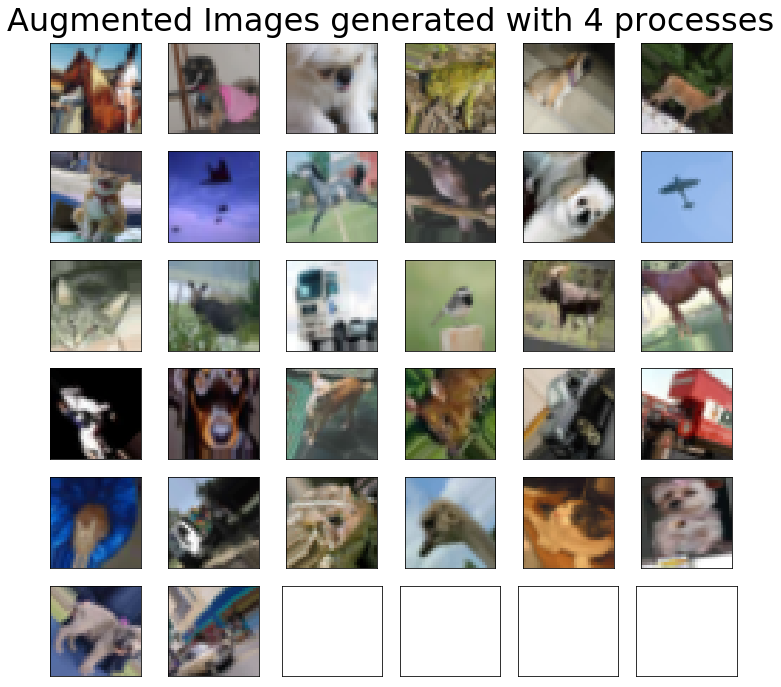

In [6]:
try:
    pool.terminate()
except:
    pass
n_process = 4
    
pool = multiprocessing.Pool(processes=n_process)
start = time.time()
gen = ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=0,
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
     #preprocessing_function=preprocess_img, # disable for nicer visualization
    
     # <-------------- Only change needed!
)

gen.fit(X_train)
X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

print('{} process, duration: {}'.format(4, time.time() - start))
plot_images(X_train_aug, 'Augmented Images generated with {} processes'.format(n_process))

pool.terminate()

In [7]:
durs = collections.defaultdict(list)
num_cores = 2
try:
    num_cores = multiprocessing.cpu_count()
except:
    pass

for j in range(10):
    print('Round', j)
    
    for num_p in range(0, num_cores + 1):
        pool = None
        if num_p > 0:
            pool = multiprocessing.Pool(processes=num_p)
            
        start = time.time()
        gen = ImageDataGenerator(
             featurewise_center=False,
             samplewise_center=False,
             featurewise_std_normalization=False,
             samplewise_std_normalization=False,
             zca_whitening=False,
             rotation_range=45,
             width_shift_range=.1,
             height_shift_range=.1,
             shear_range=0.,
             zoom_range=0,
             channel_shift_range=0,
             fill_mode='nearest',
             cval=0.,
             horizontal_flip=True,
             vertical_flip=False,
             rescale=None,
             preprocessing_function=preprocess_img,
             
        )

        gen.fit(X_train)
        X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

        for i, (imgs, labels) in enumerate(X_train_aug):
            if i == 1000:
                break

        dur = time.time() - start
        #print(num_p, dur)
        sys.stdout.write('{}: {} ... '.format(num_p, dur))
        sys.stdout.flush()
        
        durs[num_p].append(dur)

        if pool:
            pool.terminate()

Round 0
0: 16.72299838066101 ... 1: 17.252094984054565 ... 2: 17.34746241569519 ... 3: 17.28148651123047 ... 4: 17.37542223930359 ... Round 1
0: 16.817791223526 ... 1: 17.360278367996216 ... 2: 17.508697509765625 ... 3: 17.44568157196045 ... 4: 17.332334995269775 ... Round 2
0: 16.887378692626953 ... 1: 17.29352855682373 ... 2: 17.30807876586914 ... 3: 17.239150524139404 ... 4: 17.337313890457153 ... Round 3
0: 16.90267252922058 ... 1: 17.20386266708374 ... 2: 17.510079860687256 ... 3: 17.229776859283447 ... 4: 17.279890298843384 ... Round 4
0: 16.919172525405884 ... 1: 17.473541736602783 ... 2: 17.274638175964355 ... 3: 17.012134790420532 ... 4: 17.02083730697632 ... Round 5
0: 16.897687673568726 ... 1: 17.45954442024231 ... 2: 17.196882963180542 ... 3: 17.524507999420166 ... 4: 17.64509129524231 ... Round 6
0: 16.79727077484131 ... 1: 17.73870539665222 ... 2: 17.684157133102417 ... 3: 17.809122323989868 ... 4: 17.693508625030518 ... Round 7
0: 16.89758586883545 ... 1: 17.576467037200

In [8]:
df = pd.DataFrame(durs)
df

,0,1,2,3,4
0,16.722998,17.252095,17.347462,17.281487,17.375422
1,16.817791,17.360278,17.508698,17.445682,17.332335
2,16.887379,17.293529,17.308079,17.239151,17.337314
3,16.902673,17.203863,17.510080,17.229777,17.279890
4,16.919173,17.473542,17.274638,17.012135,17.020837
5,16.897688,17.459544,17.196883,17.524508,17.645091
6,16.797271,17.738705,17.684157,17.809122,17.693509
7,16.897586,17.576467,17.716886,17.715763,17.842836
8,16.963553,17.729744,17.503362,17.550306,17.583136
9,16.402403,17.383064,17.384289,17.675119,17.553427


Text(0.5, 1.0, 'Image Augmentation time vs. # Processes')

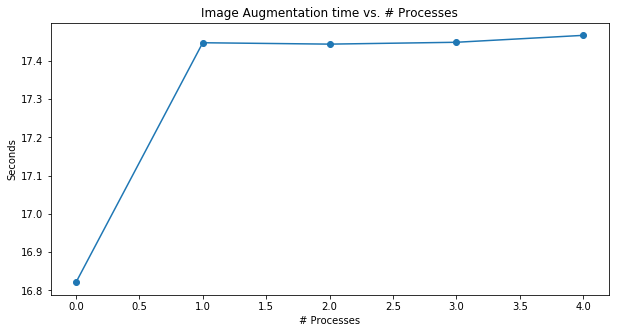

In [9]:
df_mean = pd.DataFrame(df.mean(axis=0))
plt.figure(figsize=(10,5))
plt.plot(df_mean, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Seconds')
plt.title('Image Augmentation time vs. # Processes')

Text(0.5, 1.0, 'Image Augmentation speedup vs. # Processes')

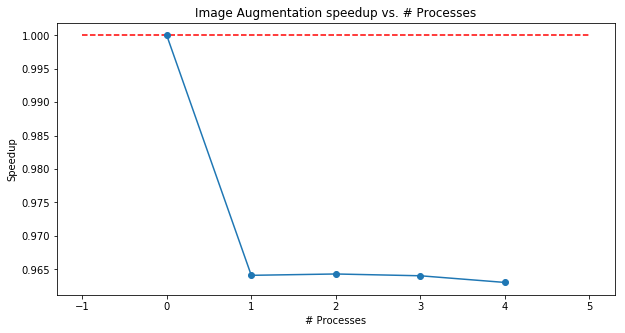

In [10]:
speedups = 1 / (df_mean / df_mean[0][0])
plt.figure(figsize=(10,5))
plt.plot(speedups, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Speedup')
plt.hlines(1, -1, df_mean.shape[0], colors='red', linestyles='dashed')
plt.title('Image Augmentation speedup vs. # Processes')

In [11]:
best_ix = np.argmax(speedups.values)
print('Best speedup: {0:.2f}x with {1} processes.'.format(speedups.values[best_ix][0], best_ix))

Best speedup: 1.00x with 0 processes.


In [14]:
!pip install tools

     |████████████████████████████████| 92kB 12.9MB/s 
  Created wheel for tools: filename=tools-0.1.9-cp36-none-any.whl size=46759 sha256=3482fc1efbd38a7da0d7d47f915781865bc14406da49d2f5ce6a81022816ac24
  Stored in directory: /root/.cache/pip/wheels/87/67/9b/1ca7dcb0b9ebfdc23a00c85a0644abb6fb14f9159a0df8e067
  Created wheel for pytils: filename=pytils-0.3-cp36-none-any.whl size=40355 sha256=643db0bec4ae1227ccb2f3bfafb4c98969d73cddbb20cf5e88651656bbf6e0ff
  Stored in directory: /root/.cache/pip/wheels/d6/f9/dc/4f07d8ee40d9cfca9973b3f4aeff99d0bb69900e5f3dffbf32
Successfully built tools pytils


In [0]:
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import psutil
import threading

from pynvml import (nvmlInit,
                     nvmlDeviceGetCount,
                     nvmlDeviceGetHandleByIndex,
                     nvmlDeviceGetUtilizationRates,
                     nvmlDeviceGetName)

def gpu_info():
    "Returns a tuple of (GPU ID, GPU Description, GPU % Utilization)"
    nvmlInit()
    deviceCount = nvmlDeviceGetCount()
    info = []
    for i in range(0, deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        util = nvmlDeviceGetUtilizationRates(handle)
        desc = nvmlDeviceGetName(handle)
        info.append((i, desc, util.gpu)) #['GPU %i - %s' % (i, desc)] = util.gpu
    return info

utils = []

class SysMonitor(threading.Thread):
    shutdown = False

    def __init__(self):
        self.utils = []
        self.start_time = time.time()
        self.duration = 0
        threading.Thread.__init__(self)

    def run(self):
        utils = []
        while not self.shutdown:
            dt = datetime.datetime.now()
            util = gpu_info()
            cpu_percent = psutil.cpu_percent()
            self.utils.append([dt] + [x[2] for x in util] + [cpu_percent])
            time.sleep(.1)

    def stop(self):
        self.shutdown = True
        self.duration = time.time() - self.start_time

    def plot(self, title, vert=False):
        if vert:
            fig, ax = plt.subplots(2, 1, figsize=(15, 6))
        else:
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(title, size=24)
        ax[0].title.set_text('GPU Utilization')
        ax[0].plot([u[1] for u in self.utils])
        ax[0].set_ylim([0, 100])
        ax[1].title.set_text('CPU Utilization')
        ax[1].plot([u[2] for u in self.utils])
        ax[1].set_ylim([0, 100])
        plt.tight_layout(rect=[0, 0.03, 1, 0.9])

In [37]:
import sysmonitor as SM
reload(SM)

ModuleNotFoundError: ignored

In [0]:
import os

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, 3, 3, border_mode='same',
                        input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  from ipykernel import kernelapp as app


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [0]:
pool = None

def init_worker():
    signal.signal(signal.SIGINT, signal.SIG_IGN)

In [0]:
def setup_generator(processes=None, batch_size=32):
    global pool
    try:
        pool.terminate()
    except:
        pass

    if processes: 
        pool = multiprocessing.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None

    gen =ImageDataGenerator(
         featurewise_center=False,
         samplewise_center=False,
         featurewise_std_normalization=False,
         samplewise_std_normalization=False,
         zca_whitening=False,
         rotation_range=45,
         width_shift_range=.1,
         height_shift_range=.1,
         shear_range=0.,
         zoom_range=[.8, 1],
         channel_shift_range=20,
         fill_mode='nearest',
         cval=0.,
         horizontal_flip=True,
         vertical_flip=False,
         rescale=None,
         preprocessing_function=preprocess_img,
         
    )
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_img,
       
    )
    
    gen.fit(X_train)
    test_gen.fit(X_train)
    
    X_train_aug = gen.flow(X_train, y_train_cat, seed=0, batch_size=batch_size)
    X_test_aug = test_gen.flow(X_test, y_test_cat, seed=0, batch_size=batch_size)
    
    return X_train_aug, X_test_aug

In [0]:
def run_benchmark(processes=None, batch_size=32, vert=True, plot=True):
    X_train_aug, X_test_aug = setup_generator(processes=processes, batch_size=batch_size)
    sys_mon = SysMonitor()
    sys_mon.start()
    
    try:
        model.fit_generator(X_train_aug, samples_per_epoch=50000, nb_epoch=5, 
                        validation_data=X_test_aug, nb_val_samples=10000)
    except KeyboardInterrupt:
        print ('\n\nTraining Interrupted\n')
        return None

    sys_mon.stop()
    
    title = None
    if not processes:
        title = '{0:.2f} seconds of computation, no multiprocessing, batch size = {1}'.format(sys_mon.duration, batch_size)
    else:
        title = '{0:.2f} seconds of computation, using {1} processes, batch size = {2}'.format(sys_mon.duration, processes, batch_size)
    
    if plot:
        sys_mon.plot(title, vert)
    
    if not processes:
        processes = 0
        
    return {
        'processes': processes,
        'batch_size': batch_size,
        'duration': sys_mon.duration,
        'title': title
    }

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=1562, epochs=5, validation_steps=10000)`
  
W0815 22:40:54.089254 140381892626304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version

Epoch 1/5
1562/1562 [==============================] - 87s 56ms/step - loss: 1.7329 - acc: 0.3635 - val_loss: 1.4178 - val_acc: 0.4789
Epoch 2/5
1562/1562 [==============================] - 80s 51ms/step - loss: 1.4612 - acc: 0.4740 - val_loss: 1.2787 - val_acc: 0.5413
Epoch 3/5
1562/1562 [==============================] - 81s 52ms/step - loss: 1.3486 - acc: 0.5158 - val_loss: 1.2190 - val_acc: 0.5669
Epoch 4/5
1562/1562 [==============================] - 84s 54ms/step - loss: 1.2832 - acc: 0.5407 - val_loss: 1.2784 - val_acc: 0.5538
Epoch 5/5
1562/1562 [==============================] - 83s 53ms/step - loss: 1.2454 - acc: 0.5574 - val_loss: 1.0636 - val_acc: 0.6205


{'batch_size': 32,
 'duration': 414.90236139297485,
 'processes': 0,
 'title': '414.90 seconds of computation, no multiprocessing, batch size = 32'}

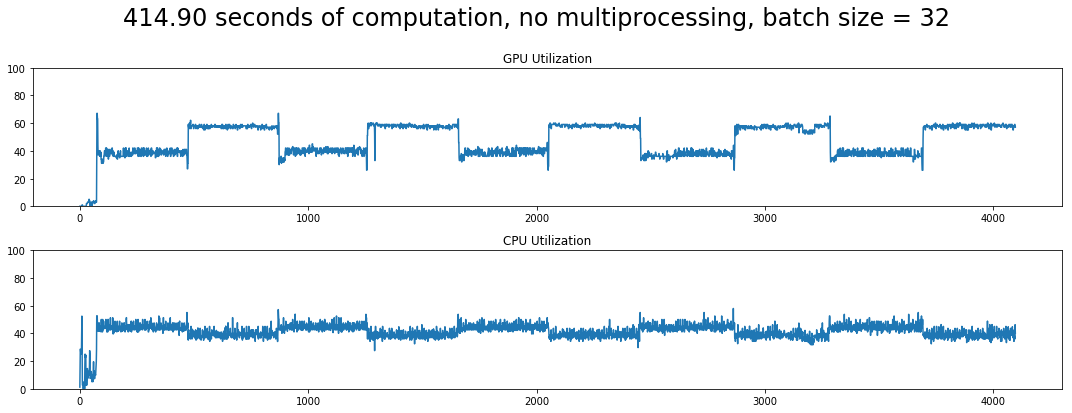

In [45]:
run_benchmark(processes=None, batch_size=32)

Epoch 1/5
   2/1562 [..............................] - ETA: 1:46 - loss: 1.2421 - acc: 0.5781

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=1562, epochs=5, validation_steps=10000)`
  


1562/1562 [==============================] - 82s 53ms/step - loss: 1.2066 - acc: 0.5723 - val_loss: 1.1221 - val_acc: 0.6079
Epoch 2/5
1562/1562 [==============================] - 81s 52ms/step - loss: 1.1810 - acc: 0.5809 - val_loss: 1.1546 - val_acc: 0.5978
Epoch 3/5
1562/1562 [==============================] - 79s 51ms/step - loss: 1.1528 - acc: 0.5928 - val_loss: 1.0481 - val_acc: 0.6334
Epoch 4/5
1562/1562 [==============================] - 78s 50ms/step - loss: 1.1447 - acc: 0.5958 - val_loss: 1.0345 - val_acc: 0.6382
Epoch 5/5
1562/1562 [==============================] - 79s 50ms/step - loss: 1.1394 - acc: 0.5967 - val_loss: 1.0587 - val_acc: 0.6321


{'batch_size': 32,
 'duration': 398.99069142341614,
 'processes': 7,
 'title': '398.99 seconds of computation, using 7 processes, batch size = 32'}

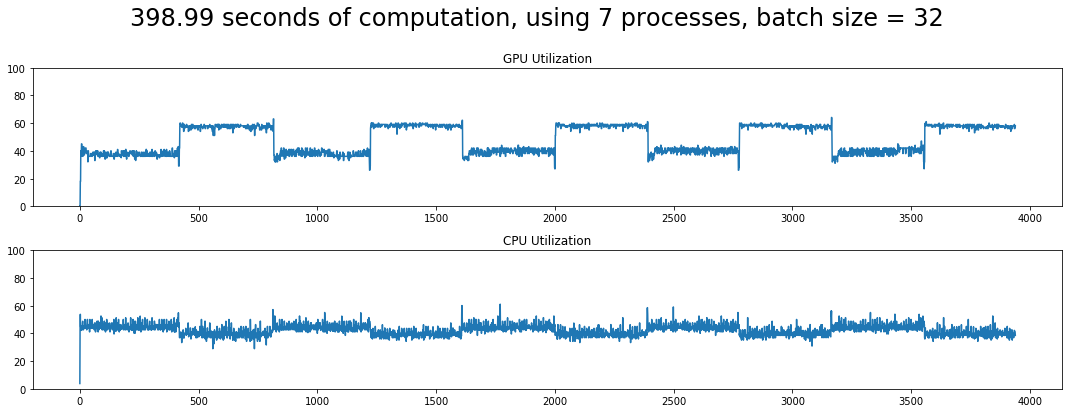

In [46]:
run_benchmark(processes=7, batch_size=32)

In [0]:
runs = []

In [0]:
runs.append(run_benchmark(processes=None, batch_size=32))

Epoch 1/5
   6/1562 [..............................] - ETA: 50s - loss: 1.0825 - acc: 0.6042 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=1562, epochs=5, validation_steps=10000)`
  


1562/1562 [==============================] - 82s 53ms/step - loss: 1.1222 - acc: 0.6049 - val_loss: 1.0162 - val_acc: 0.6446
Epoch 2/5
1562/1562 [==============================] - 79s 50ms/step - loss: 1.1020 - acc: 0.6125 - val_loss: 1.1447 - val_acc: 0.6124
Epoch 3/5
1560/1562 [============================>.] - ETA: 0s - loss: 1.1042 - acc: 0.6125

In [0]:
runs[0]['duration'] / runs[1]['duration']

In [0]:
runs.append(run_benchmark(processes=None, batch_size=256))

In [0]:
runs[2]['duration'] / runs[3]['duration']

In [0]:
runs.append(run_benchmark(processes=None, batch_size=1024))

In [0]:
runs.append(run_benchmark(processes=7, batch_size=1024))

In [0]:
runs[4]['duration'] / runs[5]['duration']


In [0]:
runs.append(run_benchmark(processes=None, batch_size=4096))


In [0]:
runs[6]['duration'] / runs[7]['duration']

In [0]:
processes_counts = [None]
processes_counts.extend(range(1, 13))

results = []

for pc in processes_counts:
    print('process count', pc)
    results.append(run_benchmark(processes=pc, batch_size=4096, plot=False))


In [0]:
durs_4096 = pd.DataFrame([x['duration'] for x in results])
plt.figure(figsize=(10,5))
plt.plot(durs_4096, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Seconds')
plt.title('Image Augmentation + GPU Training time vs. # Processes')


In [0]:
speedups_4096 = 1 / (durs_4096 / durs_4096.ix[0])

plt.figure(figsize=(10,5))
plt.plot(speedups_4096, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Speedup')
plt.hlines(1, -1, speedups_4096.shape[0], colors='red', linestyles='dashed')
plt.title('Image Augmentation + GPU Training speedup vs. # Processes')

In [0]:
best_ix = np.argmax(speedups_4096.values)
print('Best speedup: {0:.2f}x with {1} processes.'.format(speedups_4096.values[best_ix][0], best_ix))
